Frame enumuration and submission to Hyp3 with Tropo, Iono, SET corrections.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from s1_frame_enumerator import (get_s1_stack, 
                                 filter_s1_stack_by_geometric_coverage_per_pass, 
                                 get_global_s1_frames, 
                                 get_overlapping_s1_frames, 
                                 enumerate_dates, 
                                 frames2gdf, 
                                 enumerate_gunw_time_series)
from shapely.geometry import Point
import geopandas as gpd
from rasterio.crs import CRS
import matplotlib.pyplot as plt
import warnings
import json
import pandas as pd
import datetime

In [4]:
AOI_NAME = 'Somalia' #'Los Angeles' # 'Hawaii'
WEATHER_MODEL = 'ERA5'

In [5]:
if WEATHER_MODEL == 'HRRR':
    assert AOI_NAME in ['Los Angeles']

In [6]:
GEO_DICT = {'Los Angeles':  Point(-118, 34).buffer(1),
            'Hawaii': Point(-155.5, 19.5).buffer(1),
            'Somalia': Point(41, 1.5).buffer(1),
            'Tibet': Point(92, 41.5).buffer(1)
            }

TRACK_DICT = {'Los Angeles': [64],
              'Hawaii': [124],
              'Somalia': [86],
              'Tibet': [48]
              }

In [7]:
aoi_geo = GEO_DICT[AOI_NAME]
track_numbers = TRACK_DICT[AOI_NAME]

df_aoi = gpd.GeoDataFrame(geometry=[aoi_geo], crs=CRS.from_epsg(4326))

In [8]:
frames = get_overlapping_s1_frames(aoi_geo, track_numbers=track_numbers)
df_frames_all = frames2gdf(frames)
df_frames_all.head()

,frame_id,track_number_min,track_number_max,geometry
0,13403,86,87,"POLYGON Z ((40.49555 0.28046 0.00000, 40.27254..."


(-0.8211313070383549, 2.3470315701748015)

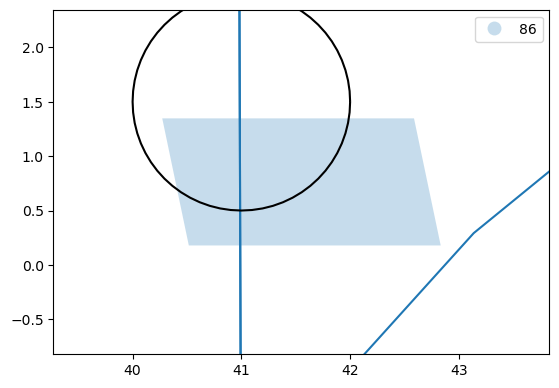

In [9]:
fig, ax = plt.subplots()
df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
df_world.boundary.plot(ax=ax)
df_frames_by_track = df_frames_all.dissolve(by='track_number_min').reset_index(drop=False)
df_frames_by_track.plot(ax=ax, 
                        column='track_number_min',
                        categorical=True,
                        alpha=.25, 
                        legend=True)
df_aoi.boundary.plot(ax=ax, edgecolor='black')
xmin, ymin, xmax, ymax = df_frames_by_track.total_bounds
ax.set_xlim(xmin - 1, xmax + 1)
ax.set_ylim(ymin - 1, ymax + 1)

(-0.8211313070383549, 2.3470315701748015)

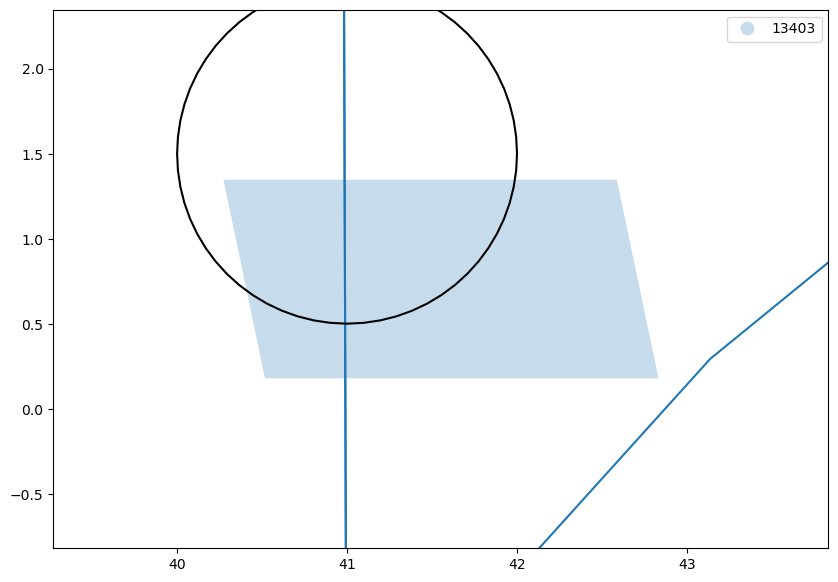

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
df_world.boundary.plot(ax=ax)
df_frames_all.plot(ax=ax, 
                   column='frame_id', 
                   alpha=.25,
                   categorical=True,
                   legend=True)
df_aoi.boundary.plot(ax=ax, edgecolor='black')

xmin, ymin, xmax, ymax = df_frames_by_track.total_bounds
ax.set_xlim(xmin - 1, xmax + 1)
ax.set_ylim(ymin - 1, ymax + 1)

# Get Stack from Frame

Here a stack is a list of images with metadata and extents. We note the stack here is not arbitrarily constructed and at some point might be nice to create a simple class to encapsulate it. However, here a stack is one that can be organized to do interferometry over the frames.

1. Per frame coverage $\geq 99$% as it pertains to the frame's coverage geometry
2. Contiguous coverage through frames (determined as Polygon object)

Requires:

1. Frames to be contiguous (otherwise 2. does not make sense)
2. Requires single track or two sequential tracks (we only check if the track numbers are sequential)

In [10]:
df_stack = get_s1_stack(frames)
df_stack.head()

,slc_id,start_time,stop_time,url,track_number,polarization,orbit,beam_mode,size_gb,stack_repeat_pass_id,repeat_pass_date,geometry
0,S1A_IW_SLC__1SDV_20150607T014908_20150607T0149...,2015-06-07 01:49:08+00:00,2015-06-07 01:49:38+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,64,VV+VH,6261,IW,4.736034,9,2015-06-07,"POLYGON ((-118.54359 32.65181, -118.13470 30.8..."
1,S1A_IW_SLC__1SDV_20150607T014936_20150607T0150...,2015-06-07 01:49:36+00:00,2015-06-07 01:50:03+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,64,VV+VH,6261,IW,4.493707,9,2015-06-07,"POLYGON ((-118.88850 34.14800, -118.51099 32.5..."
2,S1A_IW_SLC__1SDV_20150607T015000_20150607T0150...,2015-06-07 01:50:00+00:00,2015-06-07 01:50:27+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,64,VV+VH,6261,IW,4.453831,9,2015-06-07,"POLYGON ((-119.22372 35.64538, -118.84004 34.0..."
3,S1A_IW_SLC__1SSV_20150619T014909_20150619T0149...,2015-06-19 01:49:09+00:00,2015-06-19 01:49:38+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,64,VV,6436,IW,2.621702,10,2015-06-19,"POLYGON ((-118.54291 32.65313, -118.13389 30.8..."
4,S1A_IW_SLC__1SSV_20150619T014936_20150619T0150...,2015-06-19 01:49:36+00:00,2015-06-19 01:50:03+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,64,VV,6436,IW,2.429225,10,2015-06-19,"POLYGON ((-118.88759 34.14845, -118.51009 32.5..."


# Select N Most Recent Dates

In [11]:
if AOI_NAME == 'Tibet':
    N = 5
else:
    N = 3
dates = sorted(df_stack.repeat_pass_date.unique(), reverse=True)
df_stack_f = df_stack[df_stack.repeat_pass_date >= dates[N]].reset_index(drop=True)
df_stack_f.head()

,slc_id,start_time,stop_time,url,track_number,polarization,orbit,beam_mode,size_gb,stack_repeat_pass_id,repeat_pass_date,geometry
0,S1B_IW_SLC__1SDV_20211108T014900_20211108T0149...,2021-11-08 01:49:00+00:00,2021-11-08 01:49:28+00:00,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,64,VV+VH,29490,IW,3.958718,275,2021-11-08,"POLYGON ((-118.39106 32.03843, -118.01095 30.3..."
1,S1B_IW_SLC__1SDV_20211108T014926_20211108T0149...,2021-11-08 01:49:26+00:00,2021-11-08 01:49:53+00:00,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,64,VV+VH,29490,IW,4.082102,275,2021-11-08,"POLYGON ((-118.73894 33.53313, -118.36582 31.9..."
2,S1B_IW_SLC__1SDV_20211108T014950_20211108T0150...,2021-11-08 01:49:50+00:00,2021-11-08 01:50:17+00:00,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,64,VV+VH,29490,IW,4.272837,275,2021-11-08,"POLYGON ((-119.08288 35.02866, -118.70355 33.4..."
3,S1B_IW_SLC__1SDV_20211108T015015_20211108T0150...,2021-11-08 01:50:15+00:00,2021-11-08 01:50:42+00:00,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,64,VV+VH,29490,IW,4.363327,275,2021-11-08,"POLYGON ((-119.44039 36.52204, -119.05408 34.9..."
4,S1B_IW_SLC__1SDV_20211120T014900_20211120T0149...,2021-11-20 01:49:00+00:00,2021-11-20 01:49:28+00:00,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,64,VV+VH,29665,IW,4.051842,277,2021-11-20,"POLYGON ((-118.39075 32.03827, -118.01073 30.3..."


# Generate Pairs

Now we generate the frames - most important elements of returned data is:

1. SLC Ids of reference and secondary
2. Extent of related frames

In [12]:
min_temporal_baseline = 0
neighbors = 2

data = enumerate_gunw_time_series(df_stack_f, 
                                  min_temporal_baseline, 
                                  n_secondary_scenes_per_ref=neighbors,
                                  frames=frames 
                                 )

Date Pairs: 100%|█| 5/5 [00:00<00:00, 19.20it


In [13]:
len(data)

15

In [14]:
data[0]

{'reference': ['S1B_IW_SLC__1SDV_20211214T014859_20211214T014927_030015_039565_3699',
  'S1B_IW_SLC__1SDV_20211214T014924_20211214T014951_030015_039565_3340'],
 'secondary': ['S1B_IW_SLC__1SDV_20211202T014859_20211202T014927_029840_038FE0_4E26',
  'S1B_IW_SLC__1SDV_20211202T014925_20211202T014952_029840_038FE0_83EF'],
 'reference_date': datetime.date(2021, 12, 14),
 'secondary_date': datetime.date(2021, 12, 2),
 'frame_id': 9847,
 'geometry': <POLYGON Z ((-118.478 32.361 0, -118.519 32.54 0, -118.516 32.541 0, -118.70...>}

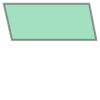

In [15]:
data[0]['geometry']

# Hyp3

In [35]:
TRACKS = ",".join([str(t) for t in TRACK_DICT[AOI_NAME]])
TODAY = datetime.datetime.now().date().strftime('%m%d')
AOI_TOKEN = AOI_NAME.replace(' ', '-')
JOB_NAME = '_'.join([AOI_TOKEN, TRACKS, WEATHER_MODEL, TODAY])
f'JOB_NAME: {JOB_NAME}'

'JOB_NAME: Los-Angeles_64_ERA5_0308'

In [34]:
f'JOB_NAME character length: {len(JOB_NAME)}'

'JOB_NAME character length: 24'

In [20]:
assert len(JOB_NAME) <= 30

In [21]:
job_parameters =  [{'granules': ifg_data['reference'],
                    'secondary_granules': ifg_data['secondary'],
                    'weather_model': WEATHER_MODEL,
                    'estimate_ionosphere_delay': True,
                    'compute_solid_earth_tide': True,
                    'frame_id': ifg_data['frame_id'],
                     } for ifg_data in data]
job_parameters[:2]

[{'granules': ['S1B_IW_SLC__1SDV_20211214T014859_20211214T014927_030015_039565_3699',
   'S1B_IW_SLC__1SDV_20211214T014924_20211214T014951_030015_039565_3340'],
  'secondary_granules': ['S1B_IW_SLC__1SDV_20211202T014859_20211202T014927_029840_038FE0_4E26',
   'S1B_IW_SLC__1SDV_20211202T014925_20211202T014952_029840_038FE0_83EF'],
  'weather_model': 'ERA5',
  'estimate_ionosphere_delay': True,
  'compute_solid_earth_tide': True,
  'frame_id': 9847},
 {'granules': ['S1B_IW_SLC__1SDV_20211214T014924_20211214T014951_030015_039565_3340',
   'S1B_IW_SLC__1SDV_20211214T014949_20211214T015016_030015_039565_1CCB'],
  'secondary_granules': ['S1B_IW_SLC__1SDV_20211202T014925_20211202T014952_029840_038FE0_83EF',
   'S1B_IW_SLC__1SDV_20211202T014950_20211202T015017_029840_038FE0_2EE7'],
  'weather_model': 'ERA5',
  'estimate_ionosphere_delay': True,
  'compute_solid_earth_tide': True,
  'frame_id': 9848}]

In [22]:
job_dicts = [{'name': JOB_NAME,
              # NOTE: we are still using the `dev` branch. Change this to "INSAR_ISCE" to use the `main` branch.
              'job_type': 'INSAR_ISCE_TEST',
              'job_parameters': parameters
             }
             for parameters in job_parameters]
job_dicts[:2]

[{'name': 'Los-Angeles_64_ERA5_0308',
  'job_type': 'INSAR_ISCE_TEST',
  'job_parameters': {'granules': ['S1B_IW_SLC__1SDV_20211214T014859_20211214T014927_030015_039565_3699',
    'S1B_IW_SLC__1SDV_20211214T014924_20211214T014951_030015_039565_3340'],
   'secondary_granules': ['S1B_IW_SLC__1SDV_20211202T014859_20211202T014927_029840_038FE0_4E26',
    'S1B_IW_SLC__1SDV_20211202T014925_20211202T014952_029840_038FE0_83EF'],
   'weather_model': 'ERA5',
   'estimate_ionosphere_delay': True,
   'compute_solid_earth_tide': True,
   'frame_id': 9847}},
 {'name': 'Los-Angeles_64_ERA5_0308',
  'job_type': 'INSAR_ISCE_TEST',
  'job_parameters': {'granules': ['S1B_IW_SLC__1SDV_20211214T014924_20211214T014951_030015_039565_3340',
    'S1B_IW_SLC__1SDV_20211214T014949_20211214T015016_030015_039565_1CCB'],
   'secondary_granules': ['S1B_IW_SLC__1SDV_20211202T014925_20211202T014952_029840_038FE0_83EF',
    'S1B_IW_SLC__1SDV_20211202T014950_20211202T015017_029840_038FE0_2EE7'],
   'weather_model': 'ERA

In [23]:
len(job_dicts)

15

You may want to use `prompt=True` to toggle between Earthdata accounts.

In [24]:
import hyp3_sdk

# uses .netrc; add `prompt=True` to prompt for credentials; 
hyp3_isce = hyp3_sdk.HyP3('https://hyp3-a19-jpl.asf.alaska.edu')

Uncomment this to submit jobs:

In [25]:
# submitted_jobs = hyp3_isce.submit_prepared_jobs(job_dicts[:])

These are useful snippets to inspect status and view metadata.

In [26]:
# jobs = hyp3_isce.find_jobs(name=JOB_NAME)
# print(jobs)

0 HyP3 Jobs: 0 succeeded, 0 failed, 0 running, 0 pending.


In [27]:
# jobs[0].to_dict()

In [28]:
# successful_jobs = hyp3_isce.find_jobs(name=JOB_NAME, status_code='SUCCEEDED')
# dicts_success = [j.to_dict() for j in successful_jobs]
# dicts_success[:]

In [29]:
# urls = [d['files'][0]['url'] for d in dicts_success]
# urls